In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
file_name = './drive/MyDrive/Colab Notebooks/data/Data_wIR.csv'
workdir = './drive/MyDrive/Colab Notebooks/model/'
data = pd.read_csv(file_name, index_col='Datetime', parse_dates=True, dtype=np.float32)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5474 entries, 2002-05-01 to 2023-04-28
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   AUDUSD_Open       5474 non-null   float32
 1   AUDUSD_High       5474 non-null   float32
 2   AUDUSD_Low        5474 non-null   float32
 3   AUDUSD_Close      5474 non-null   float32
 4   AUD_InterestRate  5474 non-null   float32
 5   EURUSD_Open       5474 non-null   float32
 6   EURUSD_High       5474 non-null   float32
 7   EURUSD_Low        5474 non-null   float32
 8   EURUSD_Close      5474 non-null   float32
 9   EUR_InterestRate  5474 non-null   float32
 10  GBPUSD_Open       5474 non-null   float32
 11  GBPUSD_High       5474 non-null   float32
 12  GBPUSD_Low        5474 non-null   float32
 13  GBPUSD_Close      5474 non-null   float32
 14  GBP_InterestRate  5474 non-null   float32
 15  USDCHF_Open       5474 non-null   float32
 16  USDCHF_High       5474 n

In [ ]:
!nvidia-smi

Tue May 23 05:10:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# N_FUTURE = 1 # predict 1 step at a time
N_FUTURE = 5 # predict 5 steps at a time
N_PAST = 50 # use 100 days worth of timesteps to predict the horizon
N_FEATURES = 6 # 'Open', 'High', 'Low', 'Close', symbol InterestRate x2
BATCH_SIZE = 128

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2, lags=100, horizon=5):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[lags:split_size+horizon]
  test_windows = windows[split_size-lags+1:-horizon]
  test_labels = labels[split_size+1:]
  return train_windows, train_labels, test_windows, test_labels

In [ ]:
# Making multivariate time series data
symbol = 'EURUSD'
columns = [f'{symbol}_Open', f'{symbol}_High', f'{symbol}_Low', f'{symbol}_Close', f'{symbol[:3]}_InterestRate', f'{symbol[-3:]}_InterestRate']

In [ ]:
windows = data[columns]
# labels = data[f"{symbol}_Close"]
labels = data[columns]
X_train, y_train, X_val, y_val = make_train_test_splits(windows, labels, lags=N_PAST, horizon=N_FUTURE) # split from '2019-02-21'
len(X_train), len(y_train), len(X_val), len(y_val)

(4379, 4334, 1139, 1094)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_train_scaled = X_train.copy()
scalers = {}
for column in columns:
  scaler = MinMaxScaler(feature_range=(-1, 1))
  X_train_scaled[column + "_scaled"] = scaler.fit_transform(X_train_scaled[column].values.reshape(-1, 1))
  X_train_scaled.drop(columns=column, inplace=True)
  scalers[column + '_scaler'] = scaler

# y_train_scaled = pd.DataFrame(y_train.copy())
# y_train_scaled[f'{symbol}_Close' + '_scaled'] = scalers[f'{symbol}_Close_scaler'].transform(y_train_scaled[f'{symbol}_Close'].values.reshape(-1, 1))
# y_train_scaled.drop(columns=f'{symbol}_Close', inplace=True)

y_train_scaled = y_train.copy()
for column in columns:
  scaler = scalers[column + '_scaler']
  y_train_scaled[column + "_scaled"] = scaler.transform(y_train_scaled[column].values.reshape(-1, 1))
  y_train_scaled.drop(columns=column, inplace=True)

X_val_scaled = X_val.copy()
for column in columns:
  scaler = scalers[column + '_scaler']
  X_val_scaled[column + "_scaled"] = scaler.transform(X_val_scaled[column].values.reshape(-1, 1))
  X_val_scaled.drop(columns=column, inplace=True)

# y_val_scaled = pd.DataFrame(y_val.copy())
# y_val_scaled[f'{symbol}_Close' + '_scaled'] = scalers[f'{symbol}_Close_scaler'].transform(y_val_scaled[f'{symbol}_Close'].values.reshape(-1, 1))
# y_val_scaled.drop(columns=f'{symbol}_Close', inplace=True)

y_val_scaled = y_val.copy()
for column in columns:
  scaler = scalers[column + '_scaler']
  y_val_scaled[column + "_scaled"] = scaler.transform(y_val_scaled[column].values.reshape(-1, 1))
  y_val_scaled.drop(columns=column, inplace=True)

In [ ]:
X_windows = tf.keras.utils.timeseries_dataset_from_array(data=X_train_scaled, targets=None, sequence_length=N_PAST, batch_size=len(X_train))
y_labels = tf.keras.utils.timeseries_dataset_from_array(data=y_train_scaled, targets=None, sequence_length=N_FUTURE, batch_size=len(y_train))

for element in zip(X_windows, y_labels):
  train_windows, train_labels = element
  assert np.array_equal(train_windows[0], X_train_scaled[:N_PAST])
  assert np.array_equal(train_labels[1], y_train_scaled[1:N_FUTURE+1])
  break

X_windows = tf.keras.utils.timeseries_dataset_from_array(data=X_val_scaled, targets=None, sequence_length=N_PAST, batch_size=len(X_val))
y_labels = tf.keras.utils.timeseries_dataset_from_array(data=y_val_scaled, targets=None, sequence_length=N_FUTURE, batch_size=len(y_val))

for element in zip(X_windows, y_labels):
  val_windows, val_labels = element
  assert np.array_equal(val_windows[0], X_val_scaled[:N_PAST])
  assert np.array_equal(val_labels[1], y_val_scaled[1:N_FUTURE+1])
  break

In [ ]:
train_windows.shape, train_labels.shape, val_windows.shape, val_labels.shape

(TensorShape([4330, 50, 6]),
 TensorShape([4330, 5, 6]),
 TensorShape([1090, 50, 6]),
 TensorShape([1090, 5, 6]))

# Create Sequence to Sequence Model with one encoder layer and one decoder layer

In [ ]:
from tensorflow.keras import layers

In [ ]:
from keras.api._v2.keras import activations
# E1D1

encoder_inputs = layers.Input(shape=(N_PAST, N_FEATURES))
encoder = layers.LSTM(100, return_state=True)
encoder_outputs = encoder(encoder_inputs)

encoder_states = encoder_outputs[1:]

decoder_inputs = layers.RepeatVector(N_FUTURE)(encoder_outputs[0])

decoder = layers.LSTM(100, return_sequences=True)(decoder_inputs, initial_state=encoder_states)
decoder_outputs = layers.TimeDistributed(layers.Dense(N_FEATURES))(decoder)

model_e1d1 = tf.keras.models.Model(encoder_inputs, decoder_outputs, name='seq2seq_model')

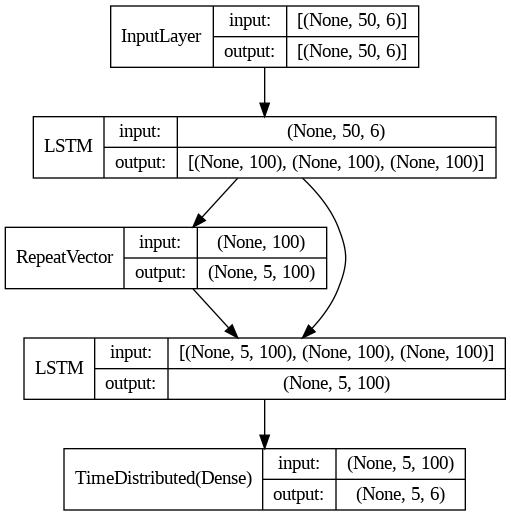

In [ ]:
tf.keras.utils.plot_model(model_e1d1, show_layer_names=False, show_shapes=True)

In [ ]:
model_e1d1.summary()

Model: "seq2seq_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 6)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        42800       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 5, 100)       0           ['lstm[0][0]']                   
                                                                                      

In [ ]:
import os

# Create a function to implement a ModelCheckPoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_checkpoint'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                                                          verbose=0, # only output a limited amount of text
                                                                          save_best_only=True) # save only the best model to file

In [ ]:
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())

history_e1d1 = model_e1d1.fit(
    train_windows,
    train_labels,
    epochs=25,
    validation_data=(val_windows, val_labels),
    batch_size=32,
    verbose=1,
    callbacks=[create_model_checkpoint(model_name=model_e1d1.name),
                       tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                              patience=100,
                                                                              restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                                         patience=5,
                                                                                         verbose=1)]
                        )

Epoch 1/25
133/136 [============================>.] - ETA: 0s - loss: 0.0084

136/136 [==============================] - 13s 63ms/step - loss: 0.0083 - val_loss: 0.0012 - lr: 0.0010
Epoch 2/25
132/136 [============================>.] - ETA: 0s - loss: 9.2311e-04

136/136 [==============================] - 9s 65ms/step - loss: 9.1796e-04 - val_loss: 9.7536e-04 - lr: 0.0010
Epoch 3/25
135/136 [============================>.] - ETA: 0s - loss: 8.6244e-04

136/136 [==============================] - 9s 63ms/step - loss: 8.6291e-04 - val_loss: 8.7932e-04 - lr: 0.0010
Epoch 4/25
136/136 [==============================] - 1s 8ms/step - loss: 7.8085e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 5/25
136/136 [==============================] - 1s 7ms/step - loss: 7.4868e-04 - val_loss: 9.8985e-04 - lr: 0.0010
Epoch 6/25
131/136 [===========================>..] - ETA: 0s - loss: 7.3463e-04

136/136 [==============================] - 8s 59ms/step - loss: 7.3603e-04 - val_loss: 8.5953e-04 - lr: 0.0010
Epoch 7/25
136/136 [==============================] - 1s 10ms/step - loss: 7.2640e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 8/25
136/136 [==============================] - 1s 10ms/step - loss: 7.0531e-04 - val_loss: 9.3689e-04 - lr: 0.0010
Epoch 9/25
129/136 [===========================>..] - ETA: 0s - loss: 6.7206e-04

136/136 [==============================] - 8s 61ms/step - loss: 6.7606e-04 - val_loss: 8.2329e-04 - lr: 0.0010
Epoch 10/25
136/136 [==============================] - 1s 7ms/step - loss: 6.6254e-04 - val_loss: 8.4857e-04 - lr: 0.0010
Epoch 11/25
136/136 [==============================] - ETA: 0s - loss: 6.5326e-04

136/136 [==============================] - 9s 65ms/step - loss: 6.5326e-04 - val_loss: 7.1921e-04 - lr: 0.0010
Epoch 12/25
136/136 [==============================] - 1s 8ms/step - loss: 6.5968e-04 - val_loss: 8.8518e-04 - lr: 0.0010
Epoch 13/25
136/136 [==============================] - 1s 7ms/step - loss: 6.5595e-04 - val_loss: 8.3389e-04 - lr: 0.0010
Epoch 14/25
136/136 [==============================] - 1s 7ms/step - loss: 6.1246e-04 - val_loss: 9.1318e-04 - lr: 0.0010
Epoch 15/25
136/136 [==============================] - 1s 10ms/step - loss: 6.4120e-04 - val_loss: 8.1695e-04 - lr: 0.0010
Epoch 16/25
136/136 [==============================] - ETA: 0s - loss: 6.0720e-04
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
136/136 [==============================] - 1s 10ms/step - loss: 6.0720e-04 - val_loss: 9.6739e-04 - lr: 0.0010
Epoch 17/25
136/136 [==============================] - 1s 8ms/step - loss: 5.3176e-04 - val_loss: 8.0459e-04 - lr: 1.0000e-04
Epo

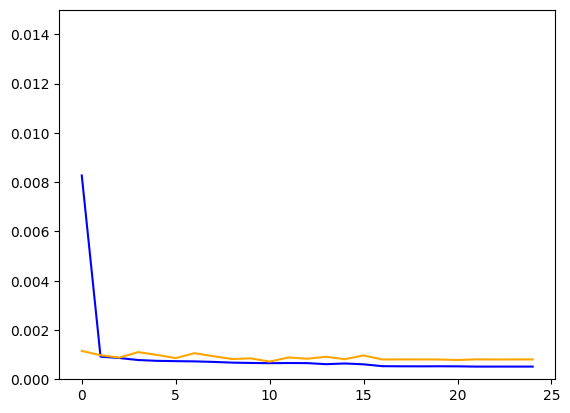

In [ ]:
plt.plot(history_e1d1.history['loss'], color='blue')
plt.plot(history_e1d1.history['val_loss'], color='orange')
# plt.xlim([500, 800])
plt.ylim([0, 0.015])
plt.show();

In [ ]:
model_e1d1 = tf.keras.models.load_model('model_checkpoint/seq2seq_model')
model_e1d1.evaluate(val_windows, val_labels)

35/35 [==============================] - 1s 4ms/step - loss: 7.1921e-04


0.0007192118209786713

In [ ]:
# Convert specific window into dtype float32 and expand_dims before model predictions
def window_expand_dims(window):
  return tf.expand_dims(tf.cast(window, dtype=tf.float32), axis=0)

In [ ]:
forecast = model_e1d1.predict(window_expand_dims(windows.iloc[iters:iters+N_PAST]))
forecast

1/1 [==============================] - 0s 24ms/step


array([[[1.0062354 , 0.82686853, 0.9964702 , 0.9529403 , 3.2618847 ,
         0.99008834],
        [1.0110044 , 0.79021883, 0.99749476, 0.9542969 , 3.2605724 ,
         1.0449528 ],
        [1.0297233 , 0.7633196 , 0.98711425, 0.95521814, 3.251591  ,
         1.0707641 ],
        [1.0278821 , 0.7384199 , 0.97149056, 0.9491069 , 3.2310705 ,
         1.0816892 ],
        [1.01468   , 0.71655375, 0.9542523 , 0.9434553 , 3.2064214 ,
         1.0837063 ]]], dtype=float32)

In [ ]:
tf.squeeze(forecast[:, :, 0].reshape(-1, 1))

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([1.0062354, 1.0110044, 1.0297233, 1.0278821, 1.01468  ],
      dtype=float32)>

In [ ]:
for i, column in enumerate(columns):
  scaler = scalers[columns[i] + '_scaler']
  scaled = scaler.inverse_transform(forecast[:, :, i].reshape(-1, 1))
  forecast[:, :, i] = tf.squeeze(scaled)

In [ ]:
forecast

array([[[1.6016791, 1.5435935, 1.5853863, 1.5833068, 9.056505 ,
         5.223982 ],
        [1.603346 , 1.5308485, 1.5857385, 1.5837793, 9.053717 ,
         5.368001 ],
        [1.6098882, 1.5214945, 1.5821699, 1.5841002, 9.03463  ,
         5.4357557],
        [1.6092447, 1.5128355, 1.5767983, 1.5819714, 8.991025 ,
         5.4644346],
        [1.6046306, 1.5052316, 1.5708718, 1.5800028, 8.938645 ,
         5.469729 ]]], dtype=float32)

In [ ]:
forecast[:, :, :-2]

array([[[1.0062354 , 0.82686853, 0.9964702 , 0.9529403 ],
        [1.0110044 , 0.79021883, 0.99749476, 0.9542969 ],
        [1.0297233 , 0.7633196 , 0.98711425, 0.95521814],
        [1.0278821 , 0.7384199 , 0.97149056, 0.9491069 ],
        [1.01468   , 0.71655375, 0.9542523 , 0.9434553 ]]], dtype=float32)

In [ ]:
np.mean(forecast[:, :, :-2], axis=-1)

array([[0.9456286 , 0.9382537 , 0.9338438 , 0.92172486, 0.9072353 ]],
      dtype=float32)

In [ ]:
forecast[0, :, 3].reshape(-1, 1)

array([[0.9529403 ],
       [0.9542969 ],
       [0.95521814],
       [0.9491069 ],
       [0.9434553 ]], dtype=float32)

In [ ]:
scaler = scalers[f"{symbol}_Close_scaler"]
scaler.inverse_transform(forecast[0, :, 3].reshape(-1, 1))

array([[1.5833068],
       [1.5837793],
       [1.5841002],
       [1.5819714],
       [1.5800028]], dtype=float32)

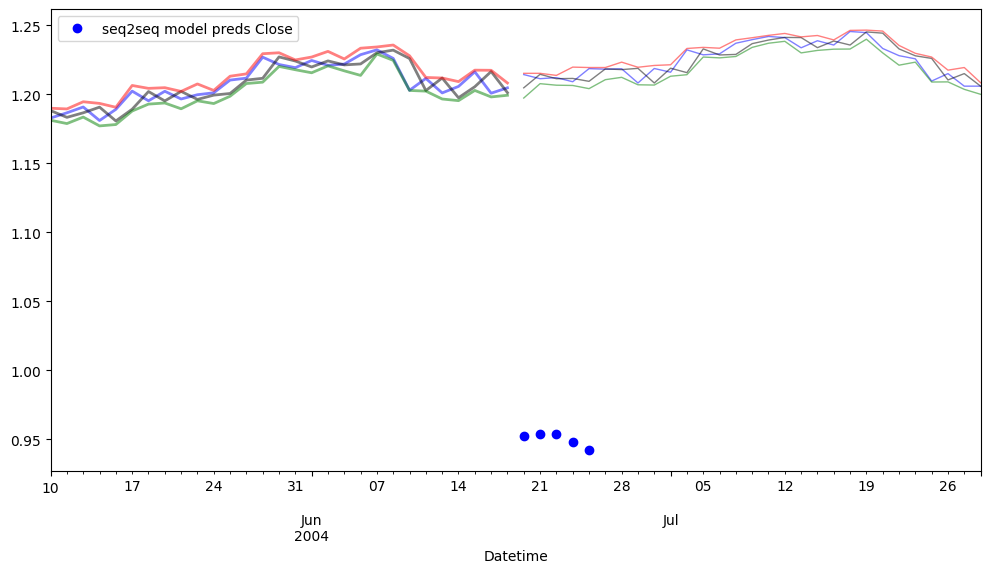

None

KeyboardInterrupt: ignored

In [ ]:
from IPython import display
import time, timeit
import matplotlib.pyplot as plt

# Initialize data windows ploting
symbol = 'EURUSD'
iters = 500
# start_step = WINDOW_SIZE + iters
interval_steps = 29 # for plot viewing

for i in range(100):
  # model prediction
  forecast = model_e1d1.predict(window_expand_dims(windows.iloc[iters:iters+N_PAST]))
  forecast = val_scaler.inverse_transform(forecast)

  # prepare ploting
  preds_step = N_PAST + iters
  start_view = preds_step - interval_steps
  end_view = preds_step + interval_steps
  forecast = pd.DataFrame(forecast[0, :, 3], index=windows.iloc[list(range(preds_step, preds_step+N_FUTURE))].index, columns=['seq2seq model preds Close'])

  # ploting
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

  data[start_view:preds_step][f'{symbol}_Close'].plot(ax=ax, linewidth=2, label='hist_Close', color='blue', alpha=0.5)
  data[preds_step:end_view][f'{symbol}_Close'].plot(ax=ax, linewidth=1, label='future_Close', color='blue', alpha=0.5)
  data[start_view:preds_step][f'{symbol}_Open'].plot(ax=ax, linewidth=2, label='hist_Open', color='black', alpha=0.5)
  data[preds_step:end_view][f'{symbol}_Open'].plot(ax=ax, linewidth=1, label='future_Open', color='black', alpha=0.5)
  data[start_view:preds_step][f'{symbol}_High'].plot(ax=ax, linewidth=2, label='hist_High', color='red', alpha=0.5)
  data[preds_step:end_view][f'{symbol}_High'].plot(ax=ax, linewidth=1, label='future_High', color='red', alpha=0.5)
  data[start_view:preds_step][f'{symbol}_Low'].plot(ax=ax, linewidth=2, label='hist_Low', color='green', alpha=0.5)
  data[preds_step:end_view][f'{symbol}_Low'].plot(ax=ax, linewidth=1, label='future_Low', color='green', alpha=0.5)

  forecast.plot(ax=ax, linewidth=4, label='seq2seq preds', color='blue', style='o')

  display.clear_output(wait=True)
  display.display(plt.show())

  iters += 1
  time.sleep(0.5)